# Credit Card Fraud Detection 

##  1: Define the Problem

Goal: Predict fraudulent credit card transactions using historical transaction data.
Target variable: 'Class' (0 = normal, 1 = fraud)
Metrics: Precision, Recall, F1-score, ROC-AUC

## 2: Load & Understand the Data

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
data = pd.read_csv("creditcard.csv")

In [4]:
# Display the first 5 rows
from IPython.display import display
display(data.head())


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Class distribution
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]
print("Fraudulent transactions:", len(fraud))
print("Valid transactions:", len(valid))
print("Fraud ratio:", len(fraud)/len(valid))

Fraudulent transactions: 492
Valid transactions: 284315
Fraud ratio: 0.0017304750013189597


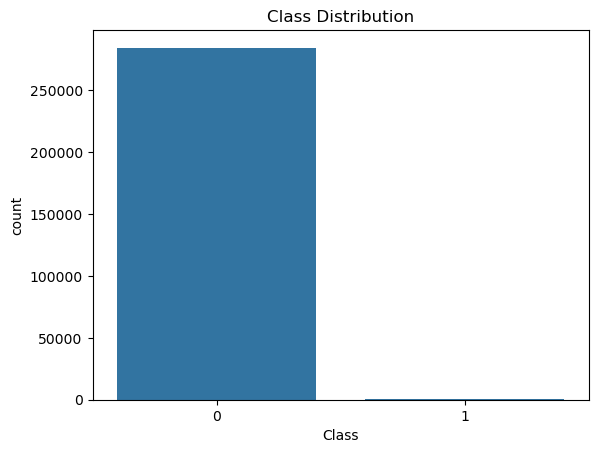

In [6]:
# Plot class distribution
sns.countplot(x='Class', data=data)
plt.title("Class Distribution")
plt.show()

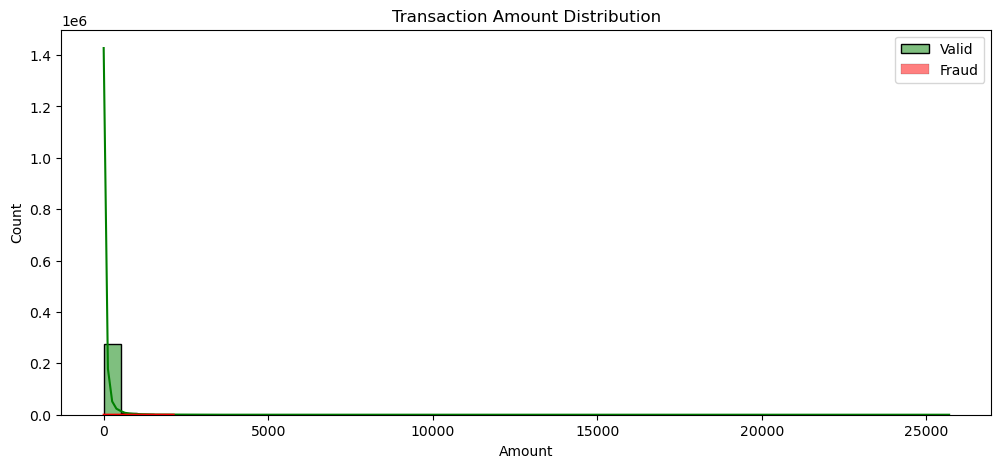

In [7]:
# Transaction amount distribution
plt.figure(figsize=(12,5))
sns.histplot(data[data['Class'] == 0]['Amount'], bins=50, color='green', label='Valid', kde=True)
sns.histplot(data[data['Class'] == 1]['Amount'], bins=50, color='red', label='Fraud', kde=True)
plt.legend()
plt.title("Transaction Amount Distribution")
plt.show()

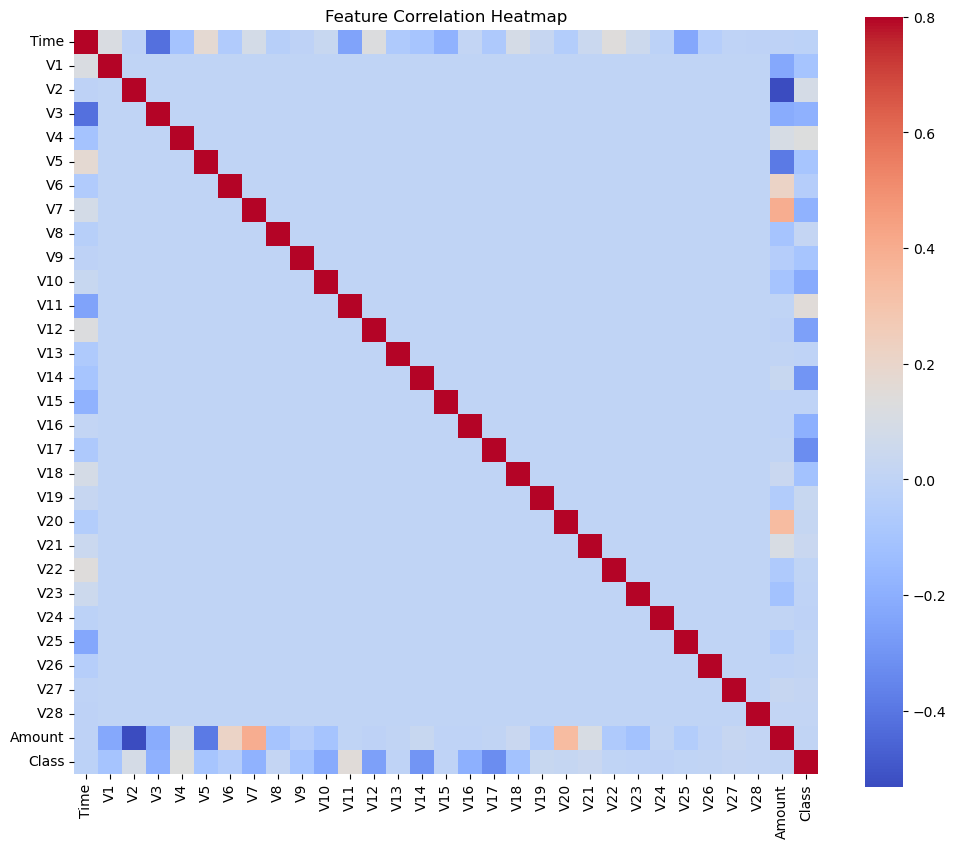

In [8]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap="coolwarm", vmax=0.8, square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

##  3: Choose Candidate Models
#1. Logistic Regression
#2. Random Forest
#3. XGBoost

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Separate features and target
X = data.drop(['Class'], axis=1)
y = data['Class']

In [11]:
# Convert to NumPy arrays
xData = X.values
yData = y.values

## 4: Split the Data

In [12]:
# Training 70%, Validation 15%, Test 15%
x_train, x_temp, y_train, y_temp = train_test_split(
    xData, yData, test_size=0.3, random_state=42, stratify=yData)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Test set:", x_test.shape, y_test.shape)

Train set: (199364, 30) (199364,)
Validation set: (42721, 30) (42721,)
Test set: (42722, 30) (42722,)


### 4a: Handle Imbalance (SMOTE)

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

Before SMOTE: [199020    344]
After SMOTE: [199020 199020]


## 5: Train Candidate Models

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


In [15]:
def evaluate_model(model, x_val, y_val):
    y_pred = model.predict(x_val)
    y_prob = model.predict_proba(x_val)[:,1] if hasattr(model, "predict_proba") else y_pred
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_prob)
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}, ROC-AUC: {roc:.4f}")
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Accuracy: 0.9911, Precision: 0.1452, Recall: 0.8514, F1-score: 0.2480, ROC-AUC: 0.9661


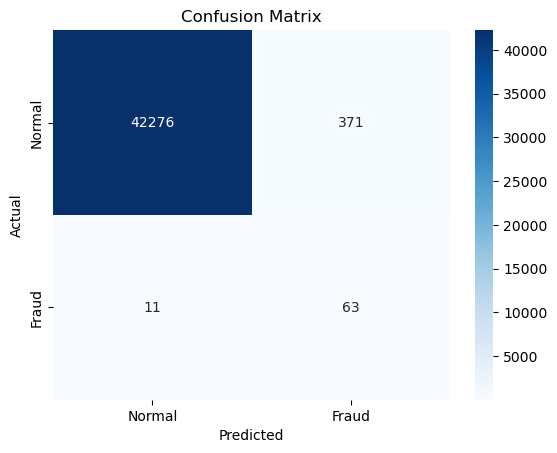

In [16]:
# ---- Logistic Regression ----
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_res)
x_val_scaled = scaler.transform(x_val)

log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(x_train_scaled, y_train_res)
evaluate_model(log_reg, x_val_scaled, y_val)


Random Forest Classifier:


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.9988, Precision: 0.6250, Recall: 0.8108, F1-score: 0.7059, ROC-AUC: 0.9744


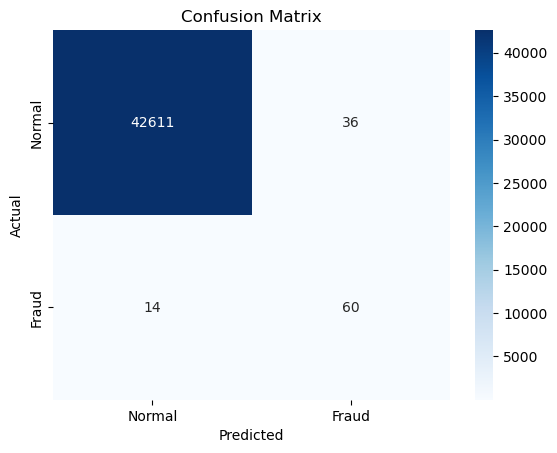

In [17]:
# ---- Random Forest ----
print("Random Forest Classifier:")
rfc = RandomForestClassifier(
    n_estimators=100, max_depth=12, min_samples_split=10, 
    min_samples_leaf=4, max_features='sqrt', 
    class_weight='balanced', n_jobs=-1, random_state=42, verbose=1
)
rfc.fit(x_train_res, y_train_res)
evaluate_model(rfc, x_val, y_val)

XGBoost Classifier:


/home/ontebogilekgakgamatso/miniconda3/envs/notebook_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:47:57] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9994, Precision: 0.8243, Recall: 0.8243, F1-score: 0.8243, ROC-AUC: 0.9827


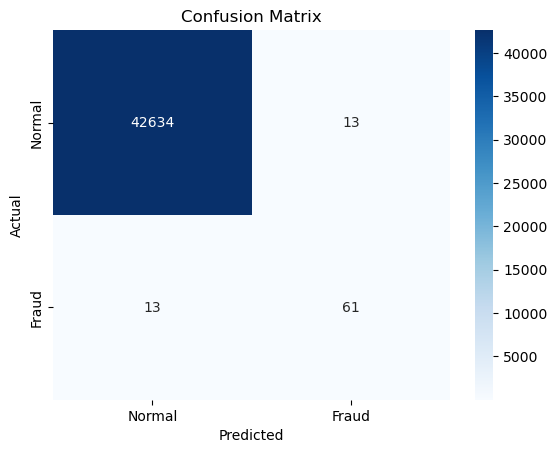

In [18]:
# ---- XGBoost ----
print("XGBoost Classifier:")
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(x_train_res, y_train_res)
evaluate_model(xgb, x_val, y_val)

## 6: Hyperparameter Tuning 

In [20]:
# ---- Safe Random Forest Hyperparameter Tuning ----
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import time

In [22]:
# Sample 50,000 indices from training set
np.random.seed(42)
sample_idx = np.random.choice(x_train_res.shape[0], 50000, replace=False)
x_sample = x_train_res[sample_idx]
y_sample = y_train_res[sample_idx]

In [23]:
# Define parameter distributions
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(8, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

In [24]:
# Randomized search
rand_search = RandomizedSearchCV(
    rfc, param_distributions=param_dist,
    n_iter=10, scoring='f1', cv=3, n_jobs=-1,
    random_state=42, verbose=1
)

In [25]:
start_time = time.time()
rand_search.fit(x_sample, y_sample)
print(f"\n✅ Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds")
print("Best parameters found:", rand_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs


✅ Hyperparameter tuning completed in 192.41 seconds
Best parameters found: {'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 121}


[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    8.7s finished


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.1s finished


Accuracy: 0.9986, Precision: 0.5596, Recall: 0.8243, F1-score: 0.6667, ROC-AUC: 0.9740


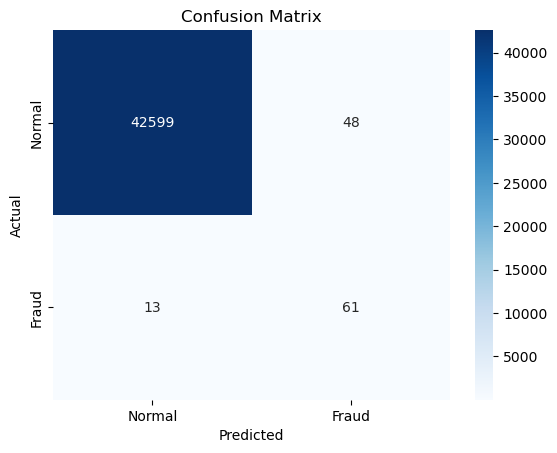

In [26]:

# Evaluate best model on validation set
best_rfc = rand_search.best_estimator_
evaluate_model(best_rfc, x_val, y_val)

## 7: Select Best Model

In [27]:
# List your models
models = {
    "Logistic Regression": log_reg,   
    "Random Forest": best_rfc,            
    "XGBoost": xgb
}

# Create a results dictionary
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": [],
    "ROC-AUC": []
}

In [28]:
# Evaluate each model
for name, model in models.items():
    y_pred = model.predict(x_val)
    y_prob = model.predict_proba(x_val)[:,1] if hasattr(model, "predict_proba") else y_pred
    
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_val, y_pred))
    results["Precision"].append(precision_score(y_val, y_pred))
    results["Recall"].append(recall_score(y_val, y_pred))
    results["F1-score"].append(f1_score(y_val, y_pred))
    results["ROC-AUC"].append(roc_auc_score(y_val, y_prob))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 out of 121 | elapsed:    0.1s finished


In [29]:
# Convert to DataFrame for nice tabular view
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score", ascending=False)  # sort by F1-score for fraud detection
print("Model Comparison on Validation Set:")
display(results_df)

Model Comparison on Validation Set:


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
2,XGBoost,0.999391,0.824324,0.824324,0.824324,0.982686
1,Random Forest,0.998572,0.559633,0.824324,0.666667,0.973983
0,Logistic Regression,0.997964,0.000000,0.000000,0.000000,0.504656


## 8: Final Evaluation of Best Model on Test Set (XGBoost)

Final Evaluation on Test Set (XGBoost):
Accuracy: 0.9994, Precision: 0.8378, Recall: 0.8378, F1-score: 0.8378, ROC-AUC: 0.9742


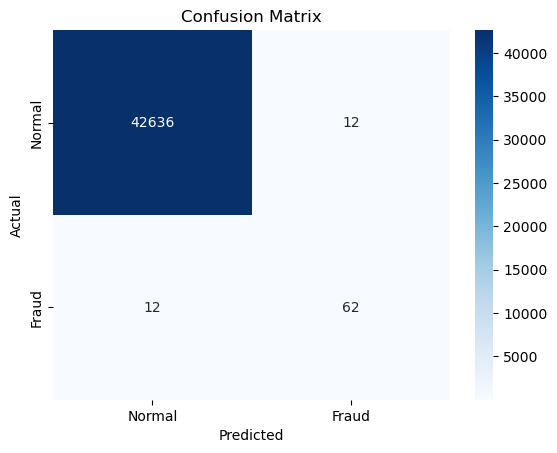

In [30]:
print("Final Evaluation on Test Set (XGBoost):")
evaluate_model(xgb, x_test, y_test)

# ROC Curve
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_test_prob = xgb.predict_proba(x_test)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

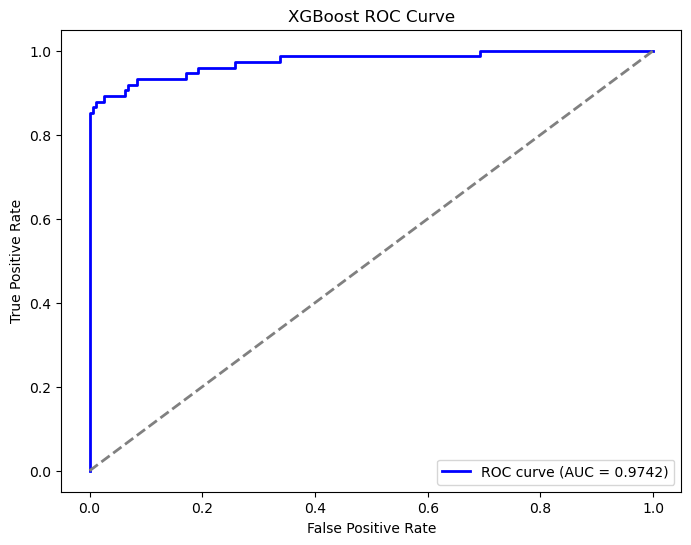

In [31]:
# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 9: Save the Model

In [32]:
import joblib
joblib.dump(xgb, 'credit_card_fraud_xgb_model.pkl')
print("Model saved as 'credit_card_fraud_xgb_model.pkl'")

Model saved as 'credit_card_fraud_xgb_model.pkl'
